In [1]:
# This program takes housing data from a town Idaho and uses it to train a model to predict housing prices based on the attributes of a house
# Import some packages for data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge

# Modify some settings
plt.rcParams['figure.figsize'] = (10, 7)
plt.rcParams['font.size'] = 16
plt.rcParams['figure.dpi'] = 150

pd.options.display.max_rows = 20
pd.options.display.max_columns = 15

np.random.seed(47)

# Import some packages to help with configuration
import os, sys
from IPython.display import Image

# read data sets
data  = pd.read_csv("data/train.csv")
training_data = pd.read_csv("data/train.csv")
testing_data = pd.read_csv("data/test.csv")
testing_data['SalePrice'] = 0

print(training_data.shape)
print(testing_data.shape)

(1460, 81)
(1459, 81)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing o

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

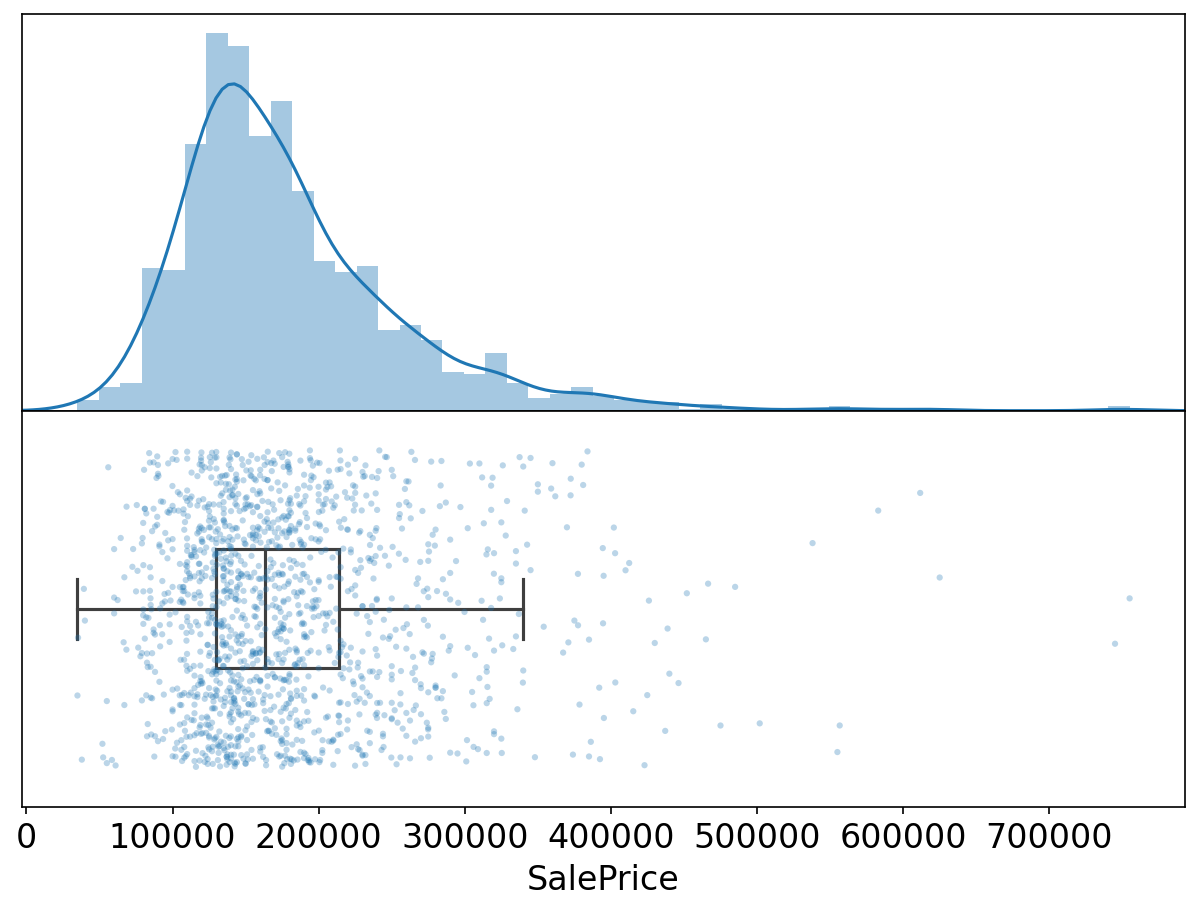

In [2]:
# generate raincloud plots
# combine histogram w density 
fig, axs = plt.subplots(nrows=2)

sns.distplot(
    training_data['SalePrice'],
    ax=axs[0]
)
sns.stripplot(
    training_data['SalePrice'],
    jitter=0.4,
    size=3,
    ax=axs[1],
    alpha=0.3
)
sns.boxplot(
    training_data['SalePrice'],
    width=0.3,
    ax=axs[1],
    showfliers=False,
)
# Align axes
spacer = np.max(training_data['SalePrice']) * 0.05
xmin = np.min(training_data['SalePrice']) - spacer
xmax = np.max(training_data['SalePrice']) + spacer
axs[0].set_xlim((xmin, xmax))
axs[1].set_xlim((xmin, xmax))

# Remove some axis text
axs[0].xaxis.set_visible(False)
axs[0].yaxis.set_visible(False)
axs[1].yaxis.set_visible(False)

# Put the two plots together
plt.subplots_adjust(hspace=0)

# Adjust boxplot fill to be white
axs[1].artists[0].set_facecolor('white')

# see summary stats
training_data['SalePrice'].describe()

In [3]:
# add column to data representing total bathrooms in a property
def add_total_bathrooms(data):
    '''
    in:
        data: table containing at least four columns of numbers
        Bsmt_Full_Bath, Full_Bath, Bsmt_Half_Bath, and Half_Bath
    out:
        copy of table with additional col TotalBathrooms
    '''
    # copy data
    with_bathrooms = data.copy()

    # fill missing vals w 0
    bath_vars = ['BsmtFullBath', 'FullBath', 'BsmtHalfBath', 'HalfBath']
    with_bathrooms = with_bathrooms.fillna({var: 0 for var in bath_vars})

    # add to TotalBathrooms col
    weights = np.array([1, 1, 0.5, 0.5])

    with_bathrooms['TotalBathrooms'] = with_bathrooms['BsmtFullBath']*weights[0] + with_bathrooms['FullBath']*weights[1] + with_bathrooms['BsmtHalfBath']*weights[2] + with_bathrooms['HalfBath']*weights[3]
    return with_bathrooms

training_data = add_total_bathrooms(training_data)

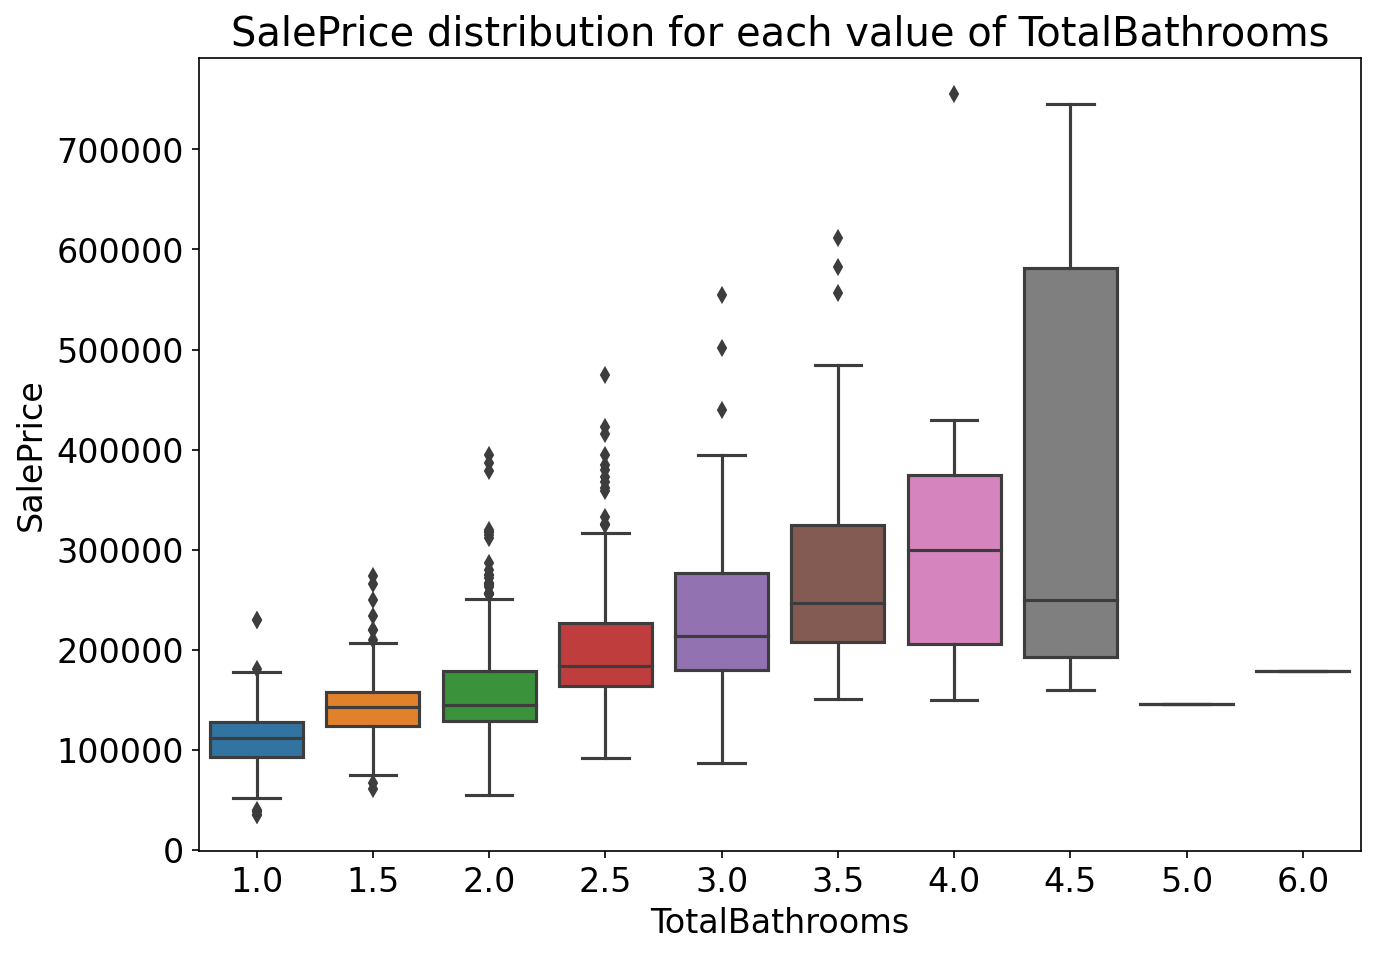

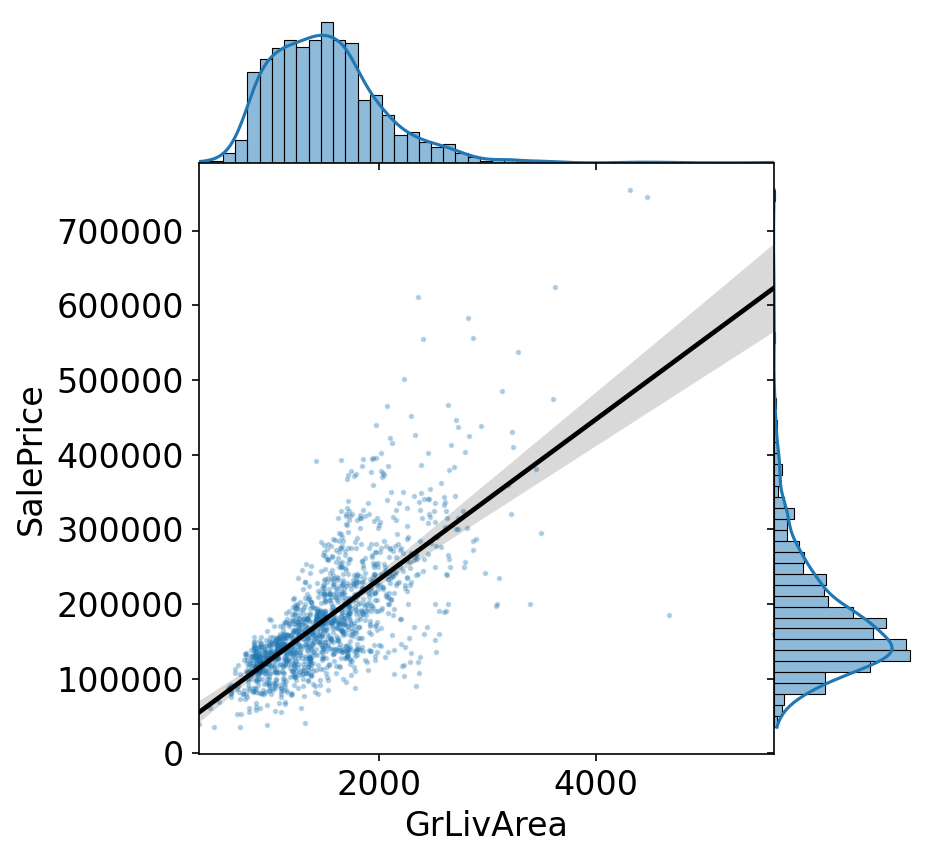

In [4]:
# look at box plots to see price ranges for diff number of bathrooms
x = 'TotalBathrooms'
y = 'SalePrice'
data = training_data
sns.boxplot(y=y, x=x, data=data)
plt.title('SalePrice distribution for each value of TotalBathrooms');

# now create new features out of old features
# first lets look at the relationship of above ground living area to sale price
sns.jointplot(
    x='GrLivArea',
    y='SalePrice',
    data=training_data,
    kind="reg",
    ratio=4,
    space=0,
    scatter_kws={
        's': 3,
        'alpha': 0.25
    },
    line_kws={
        'color': 'black'
    }
);

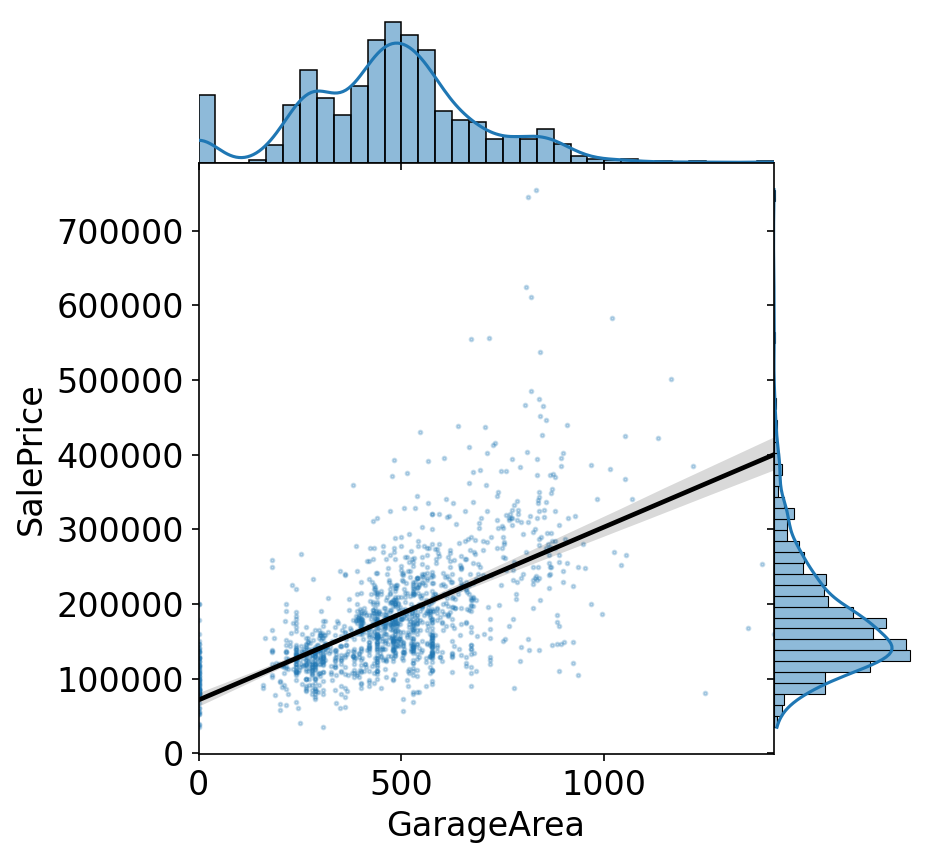

In [5]:
# now lets look at the relationship of garage area to sale price because above does not take into acount garage space
sns.jointplot(
    x='GarageArea',
    y='SalePrice',
    data=training_data,
    kind="reg",
    ratio=4,
    space=0,
    scatter_kws={
        's': 3,
        'alpha': 0.25
    },
    line_kws={
        'color': 'black'
    }
);

In [6]:
def add_power(data, column_name, degree):
    """
    Input:
        data : a table containing column called column_name column_name : a string indicating a column in the table degree: positive integer
    Output:
        copy of data containing a column called column_name<degree> with entr
    """
    with_power = data.copy()
    
    new_column_name = column_name + str(degree)
    new_column_values = with_power[column_name]**(degree)
    
    with_power[new_column_name] = new_column_values
    
    return with_power

training_data = add_power(training_data, "GarageArea", 2)
training_data = add_power(training_data, "GrLivArea", 2)

In [7]:
# now check which variable has highest corr with sale price
a = training_data['GrLivArea'].corr(training_data['SalePrice'])
b = training_data['GrLivArea2'].corr(training_data['SalePrice'])
c = training_data['GarageArea'].corr(training_data['SalePrice'])
d = training_data['GarageArea2'].corr(training_data['SalePrice'])
print(a, b, c, d)
# highest corr:
highest_variable = 'GrLivArea'


0.7086244776126523 0.6522666938824047 0.6234314389183618 0.6063005818480477


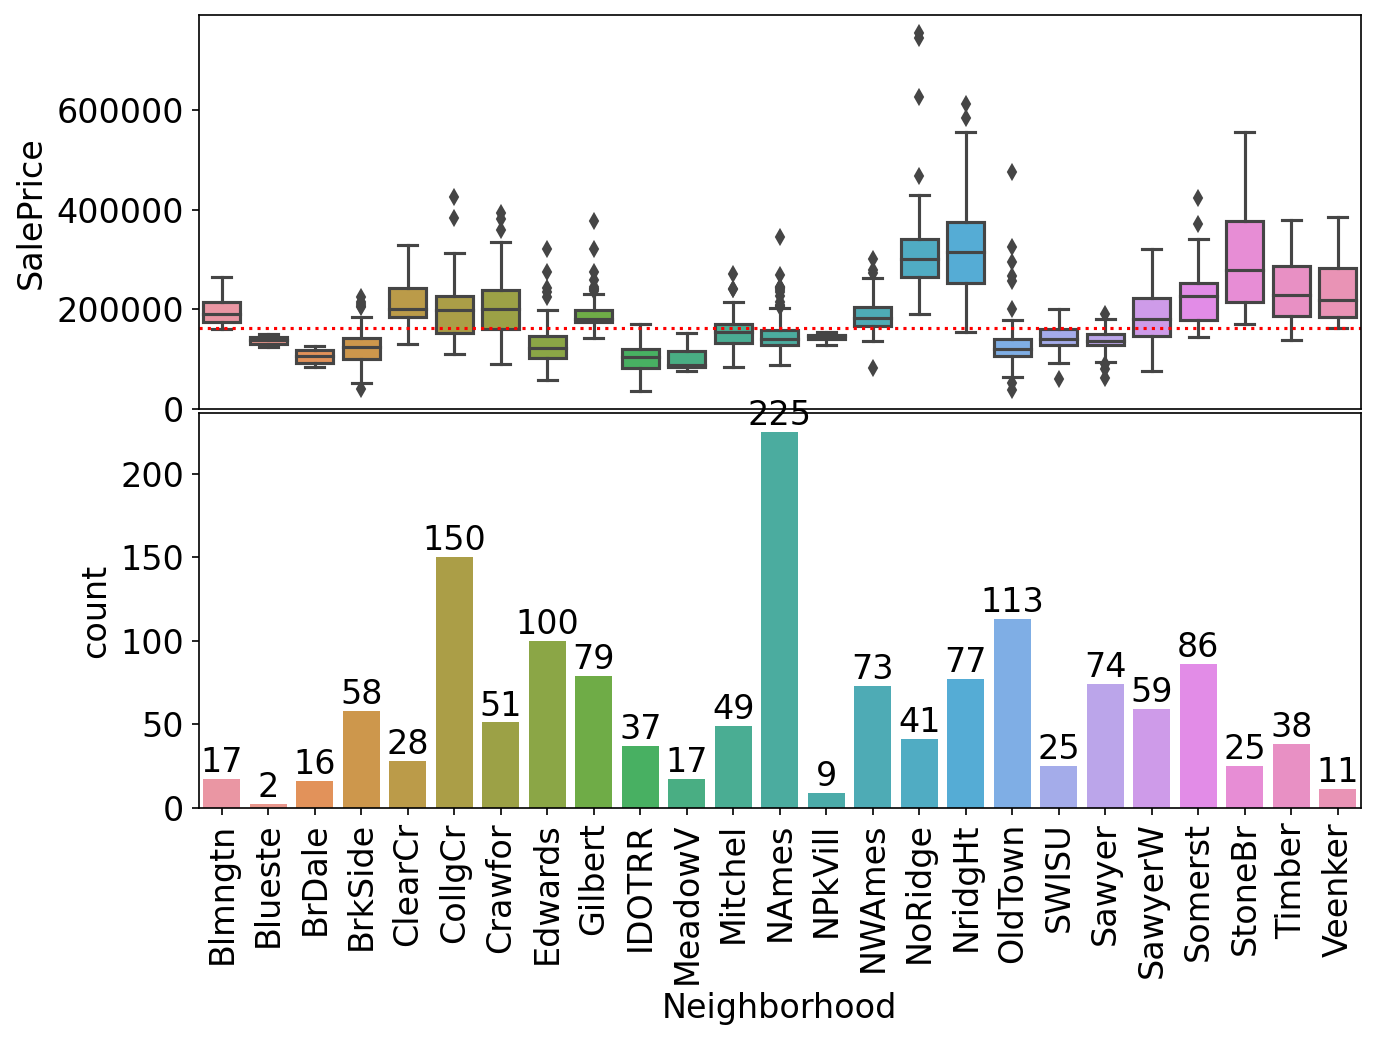

In [8]:
# now we examine relationship of neighbourhood with sale price
fig, axs = plt.subplots(nrows=2)

sns.boxplot(
    x='Neighborhood',
    y='SalePrice',
    data=training_data.sort_values('Neighborhood'),
    ax=axs[0]
)

sns.countplot(
    x='Neighborhood',
    data=training_data.sort_values('Neighborhood'),
    ax=axs[1]
)

# Draw median price
axs[0].axhline(
    y=training_data['SalePrice'].median(),
    color='red',
    linestyle='dotted'
)

# Label the bars with counts
for patch in axs[1].patches:
    x = patch.get_bbox().get_points()[:, 0]
    y = patch.get_bbox().get_points()[1, 1]
    axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')

# Format x-axes
axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
axs[0].xaxis.set_visible(False)

# Narrow the gap between the plots
plt.subplots_adjust(hspace=0.01)

In [9]:
'''
We find a lot of variation in prices across neighborhoods.
Moreover, the amount of data available is not uniformly distributed among neighborhoods.
North Ames, for example, comprises almost 15% of the training data while Green Hill has only 2 observations in this data set.
One way we can deal with the lack of data from some neighborhoods is to create a new feature that bins neighborhoods together.
Let's categorize our neighborhoods in a crude way:
we'll take the top 3 neighborhoods measured by median SalePrice and identify them as "expensive neighborhoods";
the other neighborhoods are not marked.
'''

def find_expensive_neighborhoods(data, n, summary_statistic):
    """
    Input:
        data : table containing at a column Neighborhood and a column SalePri
        n : integer indicating the number of neighborhood to return
        summary_statistic : function used for aggregating the data in each ne
    Output:
      a list of the top n richest neighborhoods as measured by the summary
    """
    neighborhoods = (training_data.groupby("Neighborhood")
                     .agg({"SalePrice" : summary_statistic})
                     .sort_values("SalePrice", ascending = False)
                     .index[:n])
                     
    return list(neighborhoods)

# top five neighborhoods on average price
find_expensive_neighborhoods(training_data, 5, np.mean)

# top three neighborhoods on meadian price
find_expensive_neighborhoods(training_data, 3, np.median)

['NridgHt', 'NoRidge', 'StoneBr']

In [10]:
expensive_neighborhood_1 = 'StoneBr'
expensive_neighborhood_2 = 'NridgHt'
expensive_neighborhood_3 = 'NoRidge'
expensive_neighborhoods = [expensive_neighborhood_1, expensive_neighborhood_2, expensive_neighborhood_3]

In [11]:
# lets add the feature in_expensive_neighborhood to training set
# write a function that adds 1 or 0 to indicate this

def add_expensive_neighborhood(data, neighborhoods):
    """
    Input:
        data : a table containing a 'Neighborhood' column neighborhoods : list of strings with names of neighborhoods
    Outtput:
        A copy of the table with an additional column in_expensive_neighborhood
    """
    with_additional_column = data.copy()
    
    with_additional_column['in_expensive_neighborhood'] = data['Neighborhood'].isin(neighborhoods)

    return with_additional_column

# add to data
training_data = add_expensive_neighborhood(training_data, expensive_neighborhoods)


In [12]:
'''
we need to normalize features for regularization.
If the features have different scales,
then regularization will unduly shrink the weights for features with smaller scales.
Write a function called normalize that inputs
either a 1 dimensional array or a 2 dimensional array Z of numbers and outputs a copy of
Z where the columns have been transformed to have mean 0 and standard deviation 1.
'''
# eg
Z = training_data[['GarageArea','GrLivArea']].values
Z_normalized = (Z - Z.mean(axis = 0)) / Z.std(axis = 0)

# normalize function
def standardize(Z):
    """
    Input:
       Z: 1 dimensional or 2 dimensional array
    Outuput
       copy of Z with columns having mean 0 and variance 1
    """
    Z_normalized = (Z - Z.mean(axis = 0)) / Z.std(axis = 0)
    return Z_normalized

# TEST
Z = training_data[['GarageArea','GrLivArea']].values
assert np.all(np.isclose(standardize(Z).mean(axis = 0), [0,0]))


In [13]:
'''
Let's split the training set into a training set and a validation set.
We will use the training set to fit our model's parameters.
We will use the validation set to estimate how well our model will perform on unseen data.
If we used all the data to fit our model,
we would not have a way to estimate model performance on unseen data.
'''

#Run to make a copy of the original training set
training_data_copy = pd.read_csv("data/train.csv")


In [14]:
'''
We will split the data in training_data_copy into
two tables named training_data and validating_data .
First we need to shuffle the indices of the table.
Note that the training set has 1998 rows.
We want to generate an array containing the number 0,1,...,1997 in random order.
'''

length_of_training_data = len(training_data_copy)
RANDOM_STATE = 47
shuffled_indices = np.random.RandomState(seed=RANDOM_STATE).permutation(length_of_training_data)


In [15]:
# split validate and train indicies into 80 / 20

train_indices = shuffled_indices[:int(length_of_training_data * 0.8)]
validate_indices = shuffled_indices[int(length_of_training_data * 0.2):]

# 
training_data = training_data_copy.iloc[train_indices]
validating_data = training_data_copy.iloc[validate_indices]


In [16]:
# to try a few different models lets create a reusable pipeline

def select_columns(data, columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]
def process_data(data):
    """Process the data for a guided model."""
    nghds = find_expensive_neighborhoods(data, n=3, summary_statistic=np.mean)
    data = (data.pipe(add_total_bathrooms)
                 .pipe(add_power,'GrLivArea', 2)
                 .pipe(add_power,'GarageArea', 2)
                 .pipe(add_expensive_neighborhood, nghds)
                 .pipe(select_columns, ['SalePrice',
                                        'GrLivArea',
                                        'GarageArea',
                                        'GrLivArea2',
                                        'GarageArea2',
                                        'TotalBathrooms',
                                        'in_expensive_neighborhood']))

    data.dropna(inplace = True)
    X = data.drop(['SalePrice'], axis = 1)
    X = standardize(X)
    y = data.loc[:, 'SalePrice']
    y = standardize(y)

    return X, y


In [17]:
'''
Note that we split our data into a table of explantory variables X and an array of response variables y .
We can use process_data to transform the training set and validation set from
earlier along with the testing set.
'''
# transformations
X_train, y_train = process_data(training_data)
X_validate, y_validate = process_data(validating_data)
X_test, y_test = process_data(testing_data)


In [18]:
'''
implement Ridge Regression.
Note that alpha is the extra parameter needed to specify the emphasis on regularization.
Large values of alpha mean greater emphasis on regularization.
'''

ridge_regression_model = Ridge(alpha = 1)
ridge_regression_model.fit(X_train, y_train)
ridge_regression_model.coef_

array([ 0.58001829,  0.26707649, -0.24318807, -0.02209564,  0.21692203,
        0.29916337])

In [19]:
# try some different values for extra parameter
models = dict()
alphas = np.logspace(-4,4,10)
for alpha in alphas:
    ridge_regression_model = Ridge(alpha = alpha)
    models[alpha] = ridge_regression_model

In [20]:
# fit each model to training data
# each key is the value of the extra parameter alpha
# each value is a ridge reg model corresponding to that alpha
for alpha, model in models.items():
    model.fit(X_train, y_train)

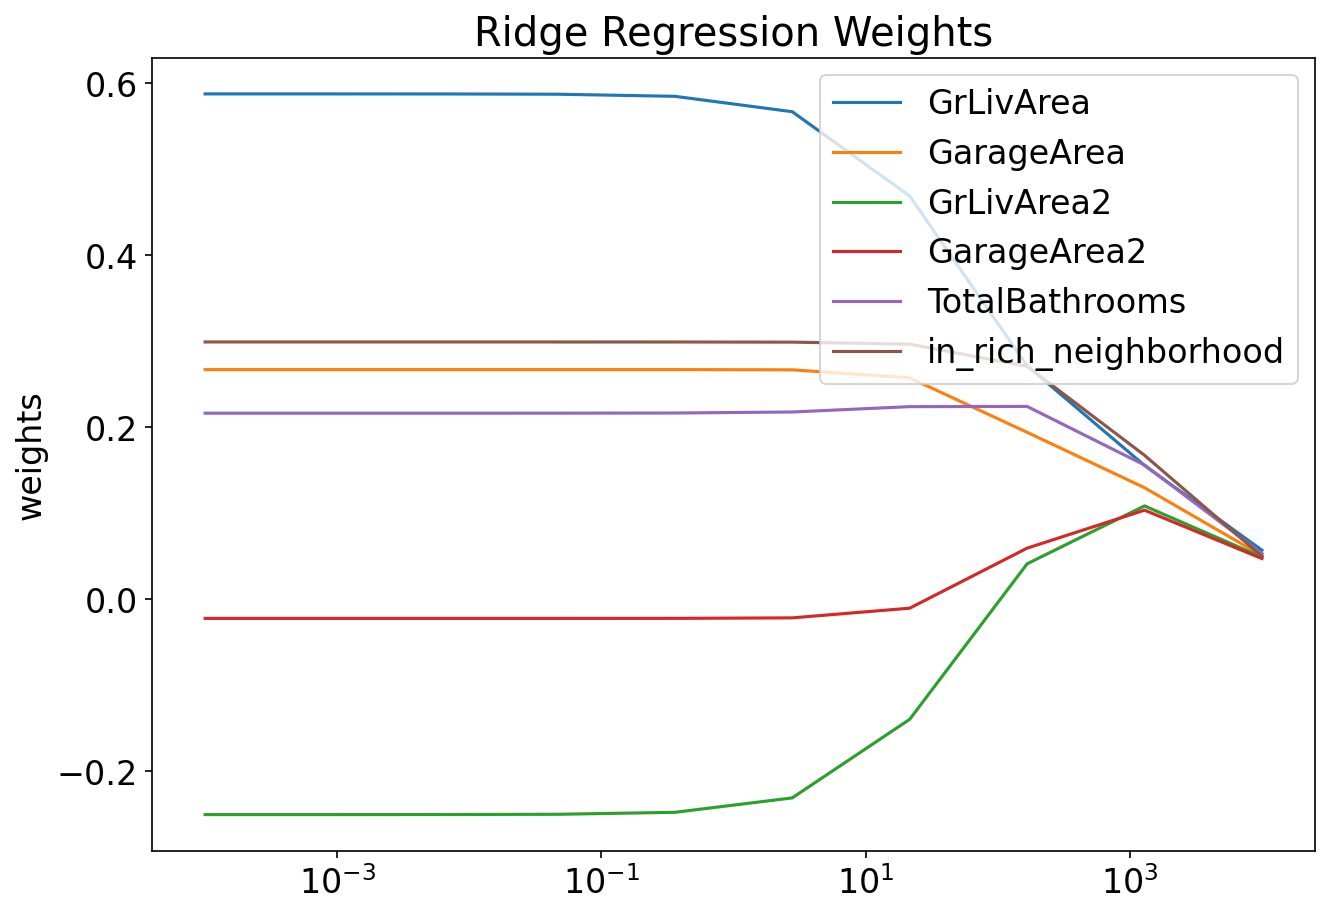

In [21]:
# plot data for each alpha
labels = ['GrLivArea',
          'GarageArea',
          'GrLivArea2',
          'GarageArea2',
          'TotalBathrooms',
          'in_rich_neighborhood']
coefs = []
for alpha, model in models.items():
    coefs.append(model.coef_)
    
coefs = zip(*coefs)

fig, ax = plt.subplots(ncols=1, nrows=1)

for coef, label in zip(coefs, labels):
    plt.plot(alphas, coef, label = label)
    
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim())
# reverse axis plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge Regression Weights')
plt.legend();

In [22]:
# lets measure the quality of our model by calculating MSE between predicted and observed house prices
def mse(observed, predicted):
    """
    Calculates RMSE from actual and predicted values
    Input:
      observed (1D array): vector of actual values
      predicted (1D array): vector of predicted/fitted values
    Output:
    a float, the root-mean square error
    """
    return np.sqrt(np.mean((observed - predicted)**2))


In [23]:
# For each alpha , we use mse to calculate the training error and validating error.
mse_training = dict()
mse_validating = dict()

for alpha, model in models.items():
    y_predict = model.predict(X_train)
    mse_training[alpha] = mse(y_predict, y_train)
    
    y_predict = model.predict(X_validate)
    mse_validating[alpha] = mse(y_predict, y_validate)
    
# store in dict where key is alpha and value is mse of model
# find min
alpha_training_min = min(mse_training.keys(), key=(lambda k: mse_training[k]))
alpha_validating_min = min(mse_validating.keys(), key=(lambda k: mse_validating[k]))



Text(0.5, 1.0, 'Residuals vs. Sale Price on Test Data')

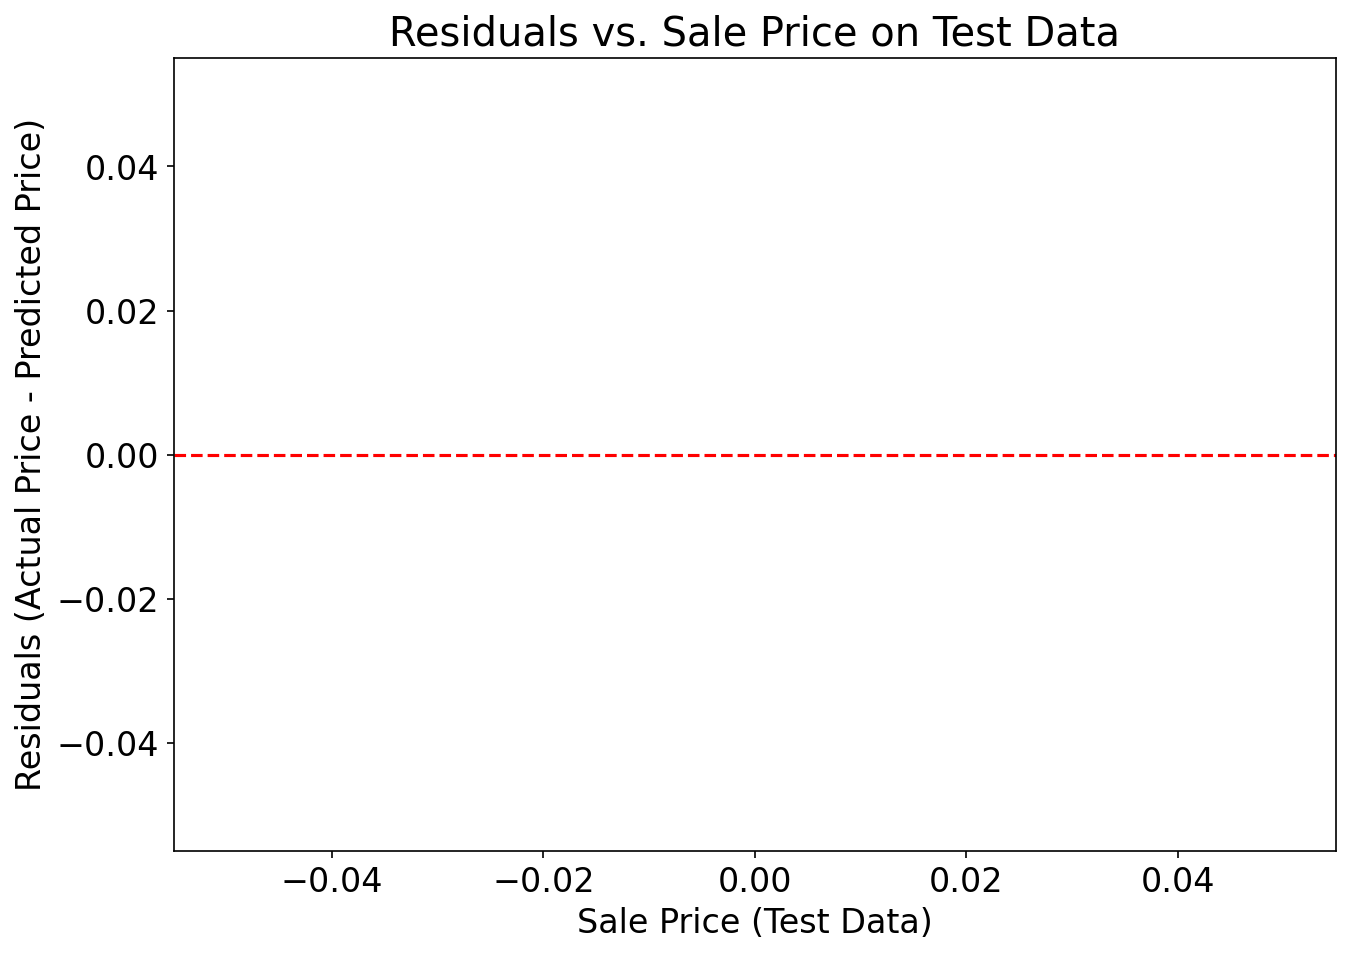

In [24]:
model = models[alpha_validating_min]
y_predict = model.predict(X_test)

# use residual plot to test appropriatness of model
residuals = y_test - y_predict

plt.axhline(y = 0, color = "red", linestyle = "dashed")
plt.scatter(y_test, residuals, alpha=0.5);

plt.xlabel('Sale Price (Test Data)')
plt.ylabel('Residuals (Actual Price - Predicted Price)')
plt.title("Residuals vs. Sale Price on Test Data")
